In [33]:
# Import our dependencies
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, recall_score
import shap



In [34]:
#  Import and read the charity_data.csv.
batter_woba_df = pd.read_csv("Resources/batting_for_learning.csv")
batter_woba_df.head()

,player_id,name,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,est_woba,est_woba_minus_woba_diff,avg_woba,woba_2023,z_scores_avg_woba,zscore_difference
0,408234,Miguel Cabrera,2020.666667,502.666667,351.333333,0.26400,0.2460,0.01800,0.36700,0.395667,-0.028667,0.30700,-0.007667,0.299333,0.290,-0.932775,0.004742
1,444482,David Peralta,2020.000000,516.250000,365.500000,0.26950,0.2540,0.01550,0.44850,0.398750,0.049750,0.31500,0.018750,0.333750,0.301,0.179349,-0.804794
2,453568,Charlie Blackmon,2020.000000,622.250000,457.500000,0.28475,0.2795,0.00525,0.47700,0.449000,0.028000,0.34325,0.008000,0.351250,0.357,0.744836,0.170167
3,455117,Martin Maldonado,2020.000000,395.750000,252.500000,0.19900,0.1945,0.00450,0.34525,0.334250,0.011000,0.26800,0.003250,0.271250,0.252,-1.840247,-0.133090
4,456781,Donovan Solano,2020.666667,292.000000,213.666667,0.29800,0.2860,0.01200,0.41500,0.425000,-0.010000,0.33100,-0.001333,0.329667,0.340,0.047402,0.399965


In [35]:
# Drop the 'Name', IDfg, 'wOBA_2023' so it is not part of the classifacation.
batter_woba_class = batter_woba_df.copy()
batter_woba_class.drop(['name', 'player_id', 'avg_woba', 'year', 'woba_2023'], axis=1, inplace=True)
batter_woba_class.dropna(axis=1, inplace=True)
batter_woba_class_encoded = batter_woba_class.copy()
batter_woba_class_encoded['zscore_difference'] = batter_woba_class_encoded['zscore_difference'].apply(lambda x: 1 if x > 0 else 0)
batter_woba_class_encoded.head()

,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,est_woba,est_woba_minus_woba_diff,z_scores_avg_woba,zscore_difference
0,502.666667,351.333333,0.26400,0.2460,0.01800,0.36700,0.395667,-0.028667,0.30700,-0.007667,-0.932775,1
1,516.250000,365.500000,0.26950,0.2540,0.01550,0.44850,0.398750,0.049750,0.31500,0.018750,0.179349,0
2,622.250000,457.500000,0.28475,0.2795,0.00525,0.47700,0.449000,0.028000,0.34325,0.008000,0.744836,1
3,395.750000,252.500000,0.19900,0.1945,0.00450,0.34525,0.334250,0.011000,0.26800,0.003250,-1.840247,0
4,292.000000,213.666667,0.29800,0.2860,0.01200,0.41500,0.425000,-0.010000,0.33100,-0.001333,0.047402,1


In [36]:
# Split our preprocessed data into our features and target arrays
X = batter_woba_class_encoded.drop('zscore_difference', axis=1)  # Features (remove the target column)
y = batter_woba_class_encoded['zscore_difference']              # Target

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (197, 11)
X_test shape: (50, 11)
y_train shape: (197,)
y_test shape: (50,)


In [37]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler on the training data
X_scaler = scaler.fit(X_train)

# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print("Selected X_train shape:", X_train_scaled.shape)
print("Selected X_test shape:", X_test_scaled.shape)
print("Selected y_train shape:", y_train.shape)

Selected X_train shape: (197, 11)
Selected X_test shape: (50, 11)
Selected y_train shape: (197,)


In [47]:
# Define your cross-validation strategy (kf)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

imb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgbclassifier', xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.01,
        n_estimators=600,
        subsample=0.5,
        colsample_bytree=0.25,
        objective='binary:logistic',
        random_state=42
    ))
])

# Use cross_val_score with the defined kf
cross_val_scores = cross_val_score(imb_pipeline, X_train_scaled, y_train, scoring='accuracy', cv=kf)

print(cross_val_scores)

imb_pipeline.fit(X_train_scaled, y_train)

y_pred = imb_pipeline.predict(X_test_scaled)

# Fit the pipeline on your training data before creating the SHAP explainer
imb_pipeline.fit(X_train_scaled, y_train)

# Extract the final estimator from the pipeline
final_estimator = imb_pipeline.named_steps['xgbclassifier']

# Create the SHAP explainer with the final estimator
explainer = shap.Explainer(final_estimator, X_train_scaled)

# Calculate SHAP values
shap_values = explainer(X_test_scaled, check_additivity=False)

[0.55       0.725      0.56410256 0.53846154 0.71794872]


In [48]:
from sklearn.metrics import balanced_accuracy_score

# Assuming you have y_test and y_pred defined
balanced_recall = balanced_accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {balanced_recall:.2f}")

Accuracy: 0.60
Recall: 0.62


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


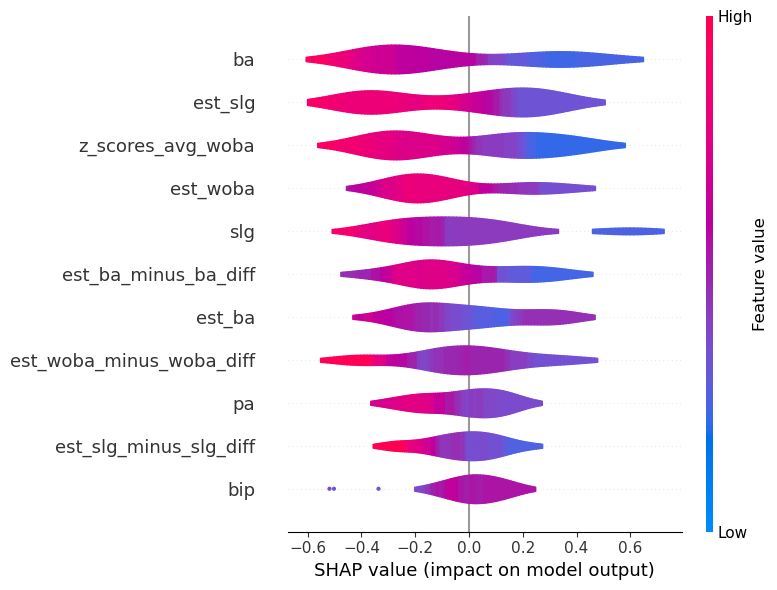

In [8]:
# Create a smaller plot
plt.figure(figsize=(8, 6))

# Generate SHAP summary plot with adjusted figsize
shap.summary_plot(shap_values, X_test_scaled, plot_type='violin', feature_names=X_train.columns, show=False)

# Get the current axes and adjust their size
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_woba_class.png', bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()



In [9]:
#  Import and read the charity_data.csv.
batter_power_df = pd.read_csv("Resources/power_for_learning.csv")
batter_power_df.head()

,player_id,name,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,avg_slg,slg_2023,z_scores_avg_slg,zscore_difference
0,408234,Miguel Cabrera,2020.666667,502.666667,351.333333,0.26400,0.2460,0.01800,0.395667,-0.028667,0.299333,0.30700,-0.007667,0.36700,0.332,-1.145143,-0.182272
1,444482,David Peralta,2020.000000,516.250000,365.500000,0.26950,0.2540,0.01550,0.398750,0.049750,0.333750,0.31500,0.018750,0.44850,0.399,0.242665,-0.596952
2,453568,Charlie Blackmon,2020.000000,622.250000,457.500000,0.28475,0.2795,0.00525,0.449000,0.028000,0.351250,0.34325,0.008000,0.47700,0.460,0.727972,-0.196277
3,455117,Martin Maldonado,2020.000000,395.750000,252.500000,0.19900,0.1945,0.00450,0.334250,0.011000,0.271250,0.26800,0.003250,0.34525,0.318,-1.515509,-0.015246
4,456781,Donovan Solano,2020.666667,292.000000,213.666667,0.29800,0.2860,0.01200,0.425000,-0.010000,0.329667,0.33100,-0.001333,0.41500,0.397,-0.327784,-0.055552


In [10]:
# Drop the 'Name', IDfg, 'wOBA_2023' so it is not part of the classifacation.
batter_power_class = batter_power_df.copy()
batter_power_class.drop(['name', 'player_id', 'year', 'avg_slg', 'slg_2023'], axis=1, inplace=True) #'avg_slg',
batter_power_class.dropna(axis=1, inplace=True)
batter_power_class_encoded = batter_power_class.copy()
batter_power_class_encoded['zscore_difference'] = batter_power_class_encoded['zscore_difference'].apply(lambda x: 1 if x > 0 else 0)
batter_power_class_encoded.head()

,pa,bip,ba,est_ba,est_ba_minus_ba_diff,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,z_scores_avg_slg,zscore_difference
0,502.666667,351.333333,0.26400,0.2460,0.01800,0.395667,-0.028667,0.299333,0.30700,-0.007667,-1.145143,0
1,516.250000,365.500000,0.26950,0.2540,0.01550,0.398750,0.049750,0.333750,0.31500,0.018750,0.242665,0
2,622.250000,457.500000,0.28475,0.2795,0.00525,0.449000,0.028000,0.351250,0.34325,0.008000,0.727972,0
3,395.750000,252.500000,0.19900,0.1945,0.00450,0.334250,0.011000,0.271250,0.26800,0.003250,-1.515509,0
4,292.000000,213.666667,0.29800,0.2860,0.01200,0.425000,-0.010000,0.329667,0.33100,-0.001333,-0.327784,0


In [11]:
# Split our preprocessed data into our features and target arrays
X = batter_power_class_encoded.drop('zscore_difference', axis=1)  # Features (remove the target column)
y = batter_power_class_encoded['zscore_difference']              # Target

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (197, 11)
X_test shape: (50, 11)
y_train shape: (197,)
y_test shape: (50,)


In [12]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler on the training data
X_scaler = scaler.fit(X_train)

# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print("Selected X_train shape:", X_train_scaled.shape)
print("Selected X_test shape:", X_test_scaled.shape)
print("Selected y_train shape:", y_train.shape)

Selected X_train shape: (197, 11)
Selected X_test shape: (50, 11)
Selected y_train shape: (197,)


In [13]:
# Define your cross-validation strategy (kf)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

imb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgbclassifier', xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.01,
        n_estimators=600,
        subsample=0.5,
        colsample_bytree=0.25,
        objective='binary:logistic',
        random_state=42
    ))
])

# Use cross_val_score with the defined kf
cross_val_scores = cross_val_score(imb_pipeline, X_train_scaled, y_train, scoring='recall', cv=kf)

print(cross_val_scores)

imb_pipeline.fit(X_train_scaled, y_train)

y_pred = imb_pipeline.predict(X_test_scaled)

# Fit the pipeline on your training data before creating the SHAP explainer
imb_pipeline.fit(X_train_scaled, y_train)

# Extract the final estimator from the pipeline
final_estimator = imb_pipeline.named_steps['xgbclassifier']

# Create the SHAP explainer with the final estimator
explainer = shap.Explainer(final_estimator, X_train_scaled)

# Calculate SHAP values
shap_values = explainer(X_test_scaled, check_additivity=False)

[0.66666667 0.61904762 0.72222222 0.64705882 0.46153846]


In [14]:
# Assuming you have y_test and y_pred defined
balanced_recall = balanced_accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {balanced_recall:.2f}")

Accuracy: 0.64
Recall: 0.67


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


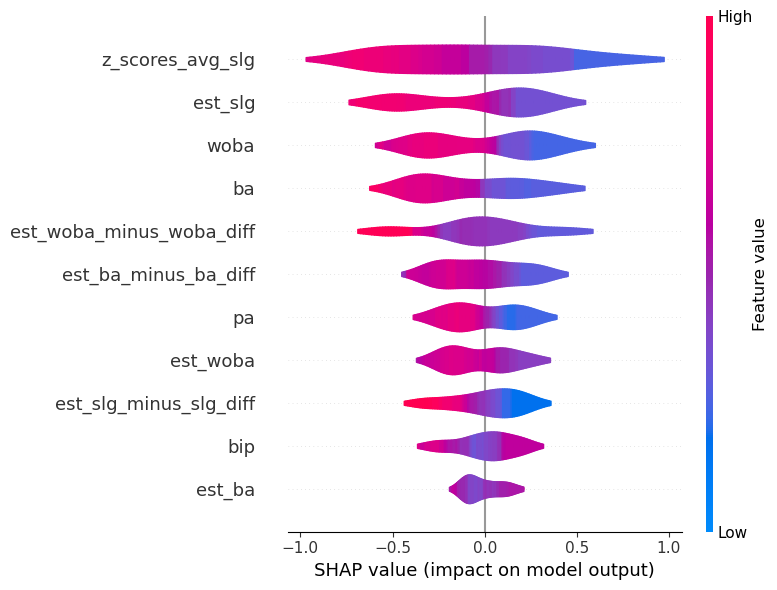

In [15]:
# Create a smaller plot
plt.figure(figsize=(8, 6))

# Generate SHAP summary plot with adjusted figsize
shap.summary_plot(shap_values, X_test_scaled, plot_type='violin', feature_names=X_train.columns, show=False)

# Get the current axes and adjust their size
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_woba_class.png', bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()



In [22]:
#  Import and read the charity_data.csv.
batter_contact_df = pd.read_csv("Resources/contact_for_learning.csv")
batter_contact_df.head()

,player_id,name,year,pa,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,avg_bip,bip_2023,z_scores_avg_bip,zscore_difference
0,408234,Miguel Cabrera,2020.666667,502.666667,0.26400,0.2460,0.01800,0.36700,0.395667,-0.028667,0.299333,0.30700,-0.007667,351.333333,195,0.199069,-1.226383
1,444482,David Peralta,2020.000000,516.250000,0.26950,0.2540,0.01550,0.44850,0.398750,0.049750,0.333750,0.31500,0.018750,365.500000,257,0.367913,-0.585828
2,453568,Charlie Blackmon,2020.000000,622.250000,0.28475,0.2795,0.00525,0.47700,0.449000,0.028000,0.351250,0.34325,0.008000,457.500000,207,1.464401,-2.335057
3,455117,Martin Maldonado,2020.000000,395.750000,0.19900,0.1945,0.00450,0.34525,0.334250,0.011000,0.271250,0.26800,0.003250,252.500000,189,-0.978861,-0.126781
4,456781,Donovan Solano,2020.666667,292.000000,0.29800,0.2860,0.01200,0.41500,0.425000,-0.010000,0.329667,0.33100,-0.001333,213.666667,223,-1.441691,0.779912


In [28]:
# Drop the 'Name', IDfg, 'wOBA_2023' so it is not part of the classifacation.
batter_contact_class = batter_contact_df.copy()
batter_contact_class.drop(['name', 'player_id', 'year', 'avg_bip', 'bip_2023'], axis=1, inplace=True) #
batter_contact_class.dropna(axis=1, inplace=True)
batter_contact_class_encoded = batter_contact_class.copy()
batter_contact_class_encoded['zscore_difference'] = batter_contact_class_encoded['zscore_difference'].apply(lambda x: 1 if x > 0 else 0)
batter_contact_class_encoded.head()

,pa,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,z_scores_avg_bip,zscore_difference
0,502.666667,0.26400,0.2460,0.01800,0.36700,0.395667,-0.028667,0.299333,0.30700,-0.007667,0.199069,0
1,516.250000,0.26950,0.2540,0.01550,0.44850,0.398750,0.049750,0.333750,0.31500,0.018750,0.367913,0
2,622.250000,0.28475,0.2795,0.00525,0.47700,0.449000,0.028000,0.351250,0.34325,0.008000,1.464401,0
3,395.750000,0.19900,0.1945,0.00450,0.34525,0.334250,0.011000,0.271250,0.26800,0.003250,-0.978861,0
4,292.000000,0.29800,0.2860,0.01200,0.41500,0.425000,-0.010000,0.329667,0.33100,-0.001333,-1.441691,1


In [29]:
# Split our preprocessed data into our features and target arrays
X = batter_contact_class_encoded.drop('zscore_difference', axis=1)  # Features (remove the target column)
y = batter_contact_class_encoded['zscore_difference']              # Target

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (197, 11)
X_test shape: (50, 11)
y_train shape: (197,)
y_test shape: (50,)


In [30]:
# Define your cross-validation strategy (kf)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

imb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgbclassifier', xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.01,
        n_estimators=600,
        subsample=0.5,
        colsample_bytree=0.25,
        objective='binary:logistic',
        random_state=42
    ))
])

# Use cross_val_score with the defined kf
cross_val_scores = cross_val_score(imb_pipeline, X_train_scaled, y_train, scoring='recall', cv=kf)

print(cross_val_scores)

imb_pipeline.fit(X_train_scaled, y_train)

y_pred = imb_pipeline.predict(X_test_scaled)

# Fit the pipeline on your training data before creating the SHAP explainer
imb_pipeline.fit(X_train_scaled, y_train)

# Extract the final estimator from the pipeline
final_estimator = imb_pipeline.named_steps['xgbclassifier']

# Create the SHAP explainer with the final estimator
explainer = shap.Explainer(final_estimator, X_train_scaled)

# Calculate SHAP values
shap_values = explainer(X_test_scaled, check_additivity=False)

[0.63636364 0.61904762 0.6        0.58333333 0.71428571]


In [31]:
# Assuming you have y_test and y_pred defined
balanced_recall = balanced_accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {balanced_recall:.2f}")

Accuracy: 0.58
Recall: 0.59


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


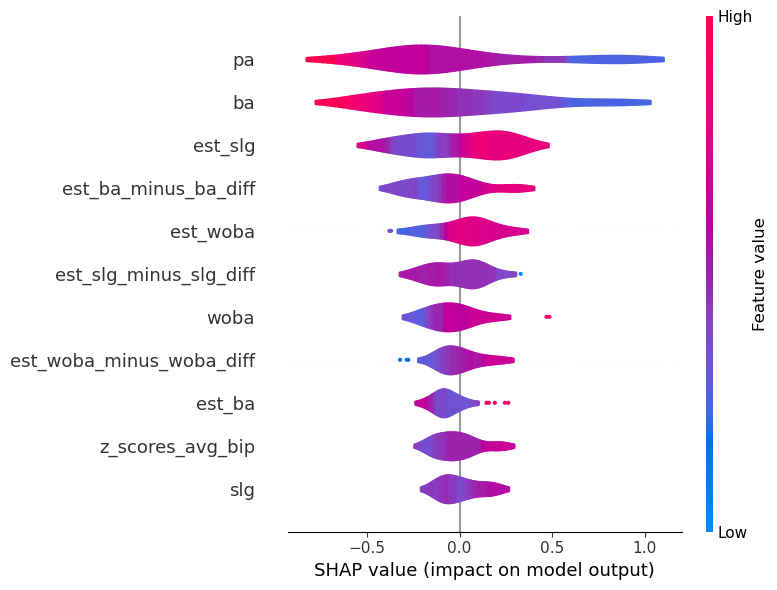

In [32]:
# Create a smaller plot
plt.figure(figsize=(8, 6))

# Generate SHAP summary plot with adjusted figsize
shap.summary_plot(shap_values, X_test_scaled, plot_type='violin', feature_names=X_train.columns, show=False)

# Get the current axes and adjust their size
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_woba_class.png', bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()

In [51]:
#  Import and read the charity_data.csv.
batter_ba_df = pd.read_csv("Resources/ba_for_learning.csv")
batter_ba_df.head()

,player_id,name,year,pa,bip,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,avg_ba,ba_2023,z_scores_avg_ba,zscore_difference
0,408234,Miguel Cabrera,2020.666667,502.666667,351.333333,0.2460,0.01800,0.36700,0.395667,-0.028667,0.299333,0.30700,-0.007667,0.26400,0.247,0.253071,-0.524163
1,444482,David Peralta,2020.000000,516.250000,365.500000,0.2540,0.01550,0.44850,0.398750,0.049750,0.333750,0.31500,0.018750,0.26950,0.271,0.468718,0.093282
2,453568,Charlie Blackmon,2020.000000,622.250000,457.500000,0.2795,0.00525,0.47700,0.449000,0.028000,0.351250,0.34325,0.008000,0.28475,0.276,1.066650,-0.331089
3,455117,Martin Maldonado,2020.000000,395.750000,252.500000,0.1945,0.00450,0.34525,0.334250,0.011000,0.271250,0.26800,0.003250,0.19900,0.180,-2.295493,-0.301316
4,456781,Donovan Solano,2020.666667,292.000000,213.666667,0.2860,0.01200,0.41500,0.425000,-0.010000,0.329667,0.33100,-0.001333,0.29800,0.280,1.586165,-0.711755


In [58]:
# Drop the 'Name', IDfg, 'wOBA_2023' so it is not part of the classifacation.
batter_ba_class = batter_ba_df.copy()
batter_ba_class.drop(['name', 'player_id', 'year', 'avg_ba', 'ba_2023'], axis=1, inplace=True) #
batter_ba_class.dropna(axis=1, inplace=True)
batter_ba_class_encoded = batter_ba_class.copy()
batter_ba_class_encoded['zscore_difference'] = batter_ba_class_encoded['zscore_difference'].apply(lambda x: 1 if x > 0 else 0)
batter_ba_class_encoded.head()

,pa,bip,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,z_scores_avg_ba,zscore_difference
0,502.666667,351.333333,0.2460,0.01800,0.36700,0.395667,-0.028667,0.299333,0.30700,-0.007667,0.253071,0
1,516.250000,365.500000,0.2540,0.01550,0.44850,0.398750,0.049750,0.333750,0.31500,0.018750,0.468718,1
2,622.250000,457.500000,0.2795,0.00525,0.47700,0.449000,0.028000,0.351250,0.34325,0.008000,1.066650,0
3,395.750000,252.500000,0.1945,0.00450,0.34525,0.334250,0.011000,0.271250,0.26800,0.003250,-2.295493,0
4,292.000000,213.666667,0.2860,0.01200,0.41500,0.425000,-0.010000,0.329667,0.33100,-0.001333,1.586165,0


In [59]:
# Split our preprocessed data into our features and target arrays
X = batter_ba_class_encoded.drop('zscore_difference', axis=1)  # Features (remove the target column)
y = batter_ba_class_encoded['zscore_difference']              # Target

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (197, 11)
X_test shape: (50, 11)
y_train shape: (197,)
y_test shape: (50,)


In [60]:
# Define your cross-validation strategy (kf)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

imb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgbclassifier', xgb.XGBClassifier(
        max_depth=5,
        learning_rate=0.01,
        n_estimators=600,
        subsample=0.5,
        colsample_bytree=0.25,
        objective='binary:logistic',
        random_state=42
    ))
])

# Use cross_val_score with the defined kf
cross_val_scores = cross_val_score(imb_pipeline, X_train_scaled, y_train, scoring='recall', cv=kf)

print(cross_val_scores)

imb_pipeline.fit(X_train_scaled, y_train)

y_pred = imb_pipeline.predict(X_test_scaled)

# Fit the pipeline on your training data before creating the SHAP explainer
imb_pipeline.fit(X_train_scaled, y_train)

# Extract the final estimator from the pipeline
final_estimator = imb_pipeline.named_steps['xgbclassifier']

# Create the SHAP explainer with the final estimator
explainer = shap.Explainer(final_estimator, X_train_scaled)

# Calculate SHAP values
shap_values = explainer(X_test_scaled, check_additivity=False)

[0.5        0.64705882 0.76190476 0.61904762 0.61538462]


In [61]:
# Assuming you have y_test and y_pred defined
balanced_recall = balanced_accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {balanced_recall:.2f}")

Accuracy: 0.60
Recall: 0.60


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


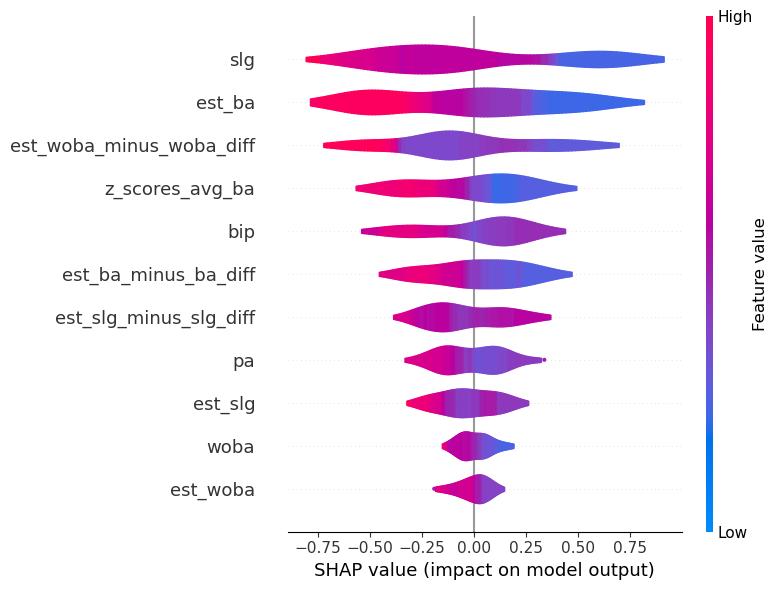

In [62]:
# Create a smaller plot
plt.figure(figsize=(8, 6))

# Generate SHAP summary plot with adjusted figsize
shap.summary_plot(shap_values, X_test_scaled, plot_type='violin', feature_names=X_train.columns, show=False)

# Get the current axes and adjust their size
ax = plt.gca()
ax.figure.set_size_inches(8, 6)
plt.savefig('Images/shap_woba_class.png', bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()